# NOTEBOOK P7 FFT LEARNABLE
bird_env: no gpu contains audiomentation
birdgpu: cuda ok

In [13]:
import torch
print('Torch imported successfully')
print(torch.cuda.is_available())       
print(torch.version.cuda)               
print(torch.backends.cudnn.version())   
print(torch.cuda.device_count()) 

Torch imported successfully
True
11.8
90100
1


In [45]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
from IPython.display import Audio
from PIL import Image, ImageOps
from PIL import Image as pil
from p7_utilities import custom_p7_melspectrogram
from p7_utilities import custom_p7_spectrograms_for_audio
from pkg_resources import parse_version
if parse_version(pil.__version__)>=parse_version('10.0.0'):
    Image.ANTIALIAS=Image.LANCZOS
    
import matplotlib.cm as cm

from STFT.stft import STFT
from STFT.stft import STFTLEARN

dataset_root_folder='/home/christophe/birdclef/'
audio_input_folder = dataset_root_folder+"train_audio"
image_output_folder = dataset_root_folder+"train_images"


# Spectrogram example

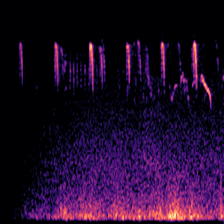

In [49]:
#generates spectrograms are generated on audio clips this long
#audio clips shorter than this are ignored
audio_duration = 5.0

#generates up to this many clips per file (multiples of audio_duration)
#remainders of audio clip length / audio_duration are ignored
max_clips_per_audio_file = 1000

#image size (image_size x image_size)
image_size = 224

#processes up to this many audio files per species
max_audio_input_per_species = 1000

#setting this above 0 will cause processing to start at a folder after the first
#useful for restarting / continuing in case of running out of time / crash (folders are processed alphabetically)
start_at_folder_offset = 0

def spectrograms_for_audio(dirname, filename, preview=False):
    # Calculate total duration of the audio file
    audio_path = os.path.join(dirname, filename)
    audio_data, sr = librosa.load(audio_path, sr=None)
    total_duration = librosa.get_duration(path=audio_path)
    
    # Determine how many full segments of audio_duration fit in the audio file
    num_segments = int(total_duration // audio_duration)
    #print('debug number f segments: ',num_segments)
    if num_segments == 0: return 0
    if num_segments > max_clips_per_audio_file: num_segments = max_clips_per_audio_file
        
    for segment in range(num_segments):

        offset_samples = int(segment * audio_duration * sr)
        end_samples = int(offset_samples + audio_duration * sr)
        
        segment_data = audio_data[offset_samples:end_samples]
        
        S = librosa.feature.melspectrogram(y=segment_data, sr=sr, n_mels=128)
        S_db = librosa.amplitude_to_db(S, ref=np.max)
                
        #convert spectrogram data into directly into image (much faster than matplotlib)
        normalized_array = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))
        
        #set color mapping 
        spectrogram_image = cm.magma(normalized_array)[:, :, :3]
        spectrogram_image = (spectrogram_image * 255).astype(np.uint8)
        spectrogram_image = Image.fromarray(spectrogram_image)
        
        #resize and flip (so consistent with original dataset)
        spectrogram_image = spectrogram_image.resize((image_size, image_size), Image.ANTIALIAS)
        spectrogram_image = ImageOps.flip(spectrogram_image)
        
        if preview:
            display(Audio(data=segment_data, rate=sr))
            return spectrogram_image
        
        output_folder = os.path.join(image_output_folder, os.path.basename(os.path.normpath(dirname)))
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Naming files with an offset to indicate seconds offset
        base_filename = filename.replace('.ogg', '')
        output_filename = os.path.join(output_folder, f"{base_filename}_{int((segment + 1) * audio_duration):02d}.png")
        
        spectrogram_image.save(output_filename)

    return num_segments
spectrograms_for_audio(f"{audio_input_folder}/zitcis1/", "XC655341.ogg", preview=True)


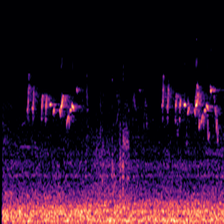

In [50]:
spectrograms_for_audio(f"{audio_input_folder}/bkcbul1/", "XC129030.ogg", preview=True)


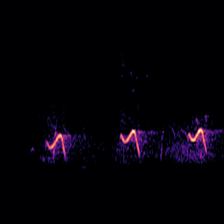

In [51]:
spectrograms_for_audio(f"{audio_input_folder}/asikoe2/", "XC138196.ogg", preview=True)

# P7 first explorations 


In [52]:
import torch

import librosa 
import matplotlib.pyplot as plt

audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"
assert os.path.exists(audio_file_test)

audio,_ = librosa.load(audio_file_test,sr=None)

audio_for_spectro=audio.copy()
device = 'cpu'
filter_length = 1024
hop_length = 256
win_length = 1024 # doesn't need to be specified. if not specified, it's the same as filter_length
window = 'hann'
librosa_stft = librosa.stft(audio, n_fft=filter_length, hop_length=hop_length, window=window)
_magnitude = np.abs(librosa_stft)

audio = torch.FloatTensor(audio)
audio = audio.unsqueeze(0)
audio = audio.to(device)

stft = STFT(
    filter_length=filter_length, 
    hop_length=hop_length, 
    win_length=win_length,
    window=window
).to(device)

magnitude, phase = stft.transform(audio)
plt.figure(figsize=(6, 6))
plt.subplot(211)
plt.title('PyTorch STFT magnitude')
plt.xlabel('Frames')
plt.ylabel('FFT bin')
plt.imshow(20*np.log10(1+magnitude[0].cpu().data.numpy()), aspect='auto', origin='lower')

plt.subplot(212)
plt.title('Librosa STFT magnitude')
plt.xlabel('Frames')
plt.ylabel('FFT bin')
plt.imshow(20*np.log10(1+_magnitude), aspect='auto', origin='lower')
plt.tight_layout()
plt.savefig('/home/christophe/birdclef/images_stft/stft.png')

output = stft.inverse(magnitude, phase)
output = output.cpu().data.numpy()[..., :]
audio = audio.cpu().data.numpy()[..., :]
assert np.allclose(output,audio,atol=1e-7) # returns false if atol=1e-7
print(np.mean((output - audio) ** 2)) # on order of 1e-17

1.8750406e-17


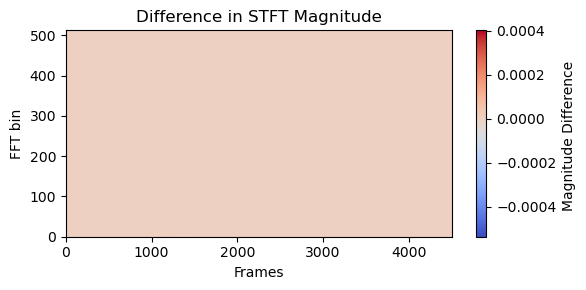

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
difference=_magnitude-magnitude[0].cpu().data.numpy()
plt.figure(figsize=(6, 3))
plt.title('Difference in STFT Magnitude')
plt.xlabel('Frames')
plt.ylabel('FFT bin')
plt.imshow(difference, aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar(label='Magnitude Difference ')
plt.tight_layout()
#plt.savefig('/home/christophe/birdclef/images_stft/difference.png')
plt.show()

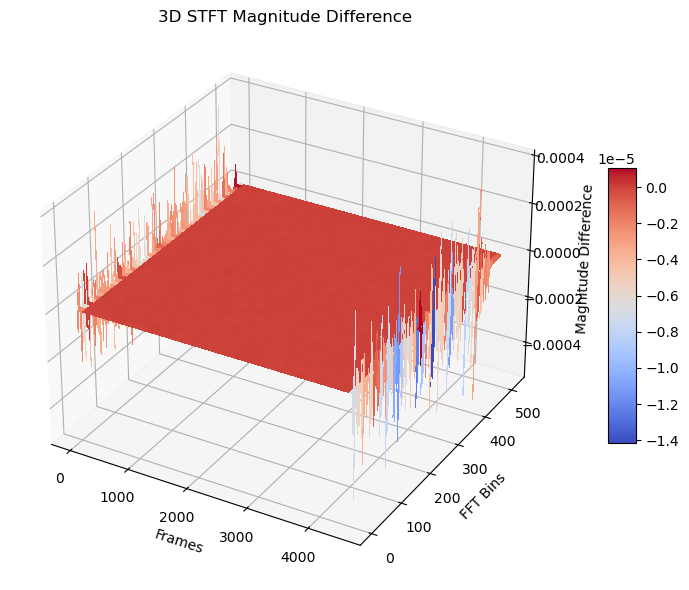

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from matplotlib import cm  # for color maps

# Assuming `difference` is already defined
difference = _magnitude - magnitude[0].cpu().data.numpy()

# Get the shape
num_bins, num_frames = difference.shape

# Create coordinate grids for X (frames) and Y (FFT bins)
X, Y = np.meshgrid(np.arange(num_frames), np.arange(num_bins))

# Create the plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(X, Y, difference, cmap='coolwarm', linewidth=0, antialiased=False)

# Labels and colorbar
ax.set_title('3D STFT Magnitude Difference')
ax.set_xlabel('Frames')
ax.set_ylabel('FFT Bins')
ax.set_zlabel('Magnitude Difference')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()


# NVIDIA TACHOTRON
Ici nous récupérons une classe tachotron fournie par NVIDIA héritant de nn.Module.
Initialement cette classe n'était pas entrainable, nous l'avons donc modifiée.
Dans notre version, mel_basis est modifiable durant l'entraînement et nous avons rajouté une méthode forward qui renvoie un spectrogramme

In [ ]:
from librosa.filters import mel as librosa_mel_fn
import random
import torch
import torch.nn as nn

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression(x, C=1):
    """
    PARAMS
    ------
    C: compression factor used to compress
    """
    return torch.exp(x) / C

class TacotronSTFT(torch.nn.Module):
    def __init__(self, filter_length=1024, hop_length=256, win_length=1024,
                 n_mel_channels=80, sampling_rate=22050, mel_fmin=0.0,
                 mel_fmax=8000.0,mel_trainable=True,fft_learnable=True,learn_win=True):
        super(TacotronSTFT, self).__init__()
        self.n_mel_channels = n_mel_channels
        self.sampling_rate = sampling_rate
        self.stft_fn = STFTLEARN(filter_length, hop_length, win_length,learn_basis=fft_learnable,learn_window=learn_win)
        self.mel_trainable=mel_trainable
        mel_basis = librosa_mel_fn(
            sr=sampling_rate, n_fft=filter_length,n_mels= n_mel_channels,fmin= mel_fmin,fmax= mel_fmax)
        
        ### mel_basis is now learnable
        if self.mel_trainable:
            self.mel_basis = nn.Parameter(torch.from_numpy(mel_basis).float())
        else:
            # initial code
            mel_basis = torch.from_numpy(mel_basis).float()
            self.register_buffer('mel_basis', mel_basis)

    def spectral_normalize(self, magnitudes):
        output = dynamic_range_compression(magnitudes)
        return output

    def spectral_de_normalize(self, magnitudes):
        output = dynamic_range_decompression(magnitudes)
        return output

    def mel_spectrogram(self, y):
        """Computes mel-spectrograms from a batch of waves
        PARAMS
        ------
        y: Variable(torch.FloatTensor) with shape (B, T) in range [-1, 1]

        RETURNS
        -------
        mel_output: torch.FloatTensor of shape (B, n_mel_channels, T)
        """

        ##### COMMENTED BECAUSE OUR DATA HAD SUCH VALUES ########
        # assert(torch.min(y.data) >= -1)
        # assert(torch.max(y.data) <= 1)

        magnitudes, phases = self.stft_fn.transform(y)
        magnitudes = magnitudes.data
        # magnitudes = magnitudes.data.float()  # Ensure float32
        # mel_basis = self.mel_basis.float()
        mel_output = torch.matmul(self.mel_basis, magnitudes)
        mel_output = self.spectral_normalize(mel_output)
        return mel_output
    
    def forward(self,y):
        return self.mel_spectrogram(y)


##### TESTS ######
tacotron_stft=TacotronSTFT()
audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"
#audio_file_test=f"{audio_input_folder}/zitcis1/XC124995.ogg"
#audio_file_test=f"{audio_input_folder}/zitcis1/XC127906.ogg"
assert os.path.exists(audio_file_test)

FS=32000
FIXED_LENGTH = int(5.0 * FS)  # 5 seconds

def get_audio_data(audio_raw_file):
    audio_data, _ = librosa.load(audio_raw_file, sr=FS)
    if len(audio_data) < FIXED_LENGTH:
        
        # Pad with zeros
        pad_width = FIXED_LENGTH - len(audio_data)
        audio_data = np.pad(audio_data, (0, pad_width), mode='constant')
    else:
        
        # Truncate
        audio_data = audio_data[:FIXED_LENGTH]

    return torch.from_numpy(audio_data).unsqueeze(0)

# test of data augmentation
def get_audio_data_augmented(audio_raw_file, apply_augmentation=True,rate_augmentation=0.5):
    audio_data, _ = librosa.load(audio_raw_file, sr=FS)
    audio_data = audio_data.astype(np.float32)


    if apply_augmentation and len(audio_data) > 0:
        # Noise Injection
        if random.random() > rate_augmentation:  
            noise = np.random.randn(len(audio_data))
            audio_data = audio_data + 0.005 * noise
            audio_data = audio_data.astype(np.float32)
            

        # Time Stretching
        if random.random() > rate_augmentation:  
            rate = random.uniform(0.8, 1.2) 
            audio_data = librosa.effects.time_stretch(audio_data, rate=rate)
            audio_data = audio_data.astype(np.float32)
            

        # Pitch Shifting
        if random.random() > rate_augmentation: 
            n_steps = random.uniform(-2, 2)  # Shift pitch by up to 2 steps
            audio_data = librosa.effects.pitch_shift(audio_data, sr=FS, n_steps=n_steps)
            audio_data = audio_data.astype(np.float32)

        # Time Shifting
        if random.random() > 2: # we don't use time shifting  
            shift_max = int(0.1 * len(audio_data)) 
            shift = random.randint(-shift_max, shift_max)
            audio_data = np.roll(audio_data, shift)
            audio_data = audio_data.astype(np.float32)

    # Pad or truncate to fixed length
    if len(audio_data) < FIXED_LENGTH:
        pad_width = FIXED_LENGTH - len(audio_data)
        audio_data = np.pad(audio_data, (0, pad_width), mode='constant')
    else:
        audio_data = audio_data[:FIXED_LENGTH]

    return torch.from_numpy(audio_data).unsqueeze(0)


# TEST
audio_torch_spectro=get_audio_data(audio_raw_file=audio_file_test)

audio_torch_spectro_2=get_audio_data_augmented(audio_raw_file=audio_file_test,apply_augmentation=False)

assert np.allclose(audio_torch_spectro.detach().numpy(),audio_torch_spectro.detach().numpy())

audio_torch_augmented=get_audio_data_augmented(audio_raw_file=audio_file_test,apply_augmentation=True)

spectro_augmented=tacotron_stft.mel_spectrogram(y=audio_torch_augmented)

spectro = tacotron_stft.mel_spectrogram(y=audio_torch_spectro)
output_tacrotron = tacotron_stft(y=audio_torch_spectro.unsqueeze(0))

print('Output of tachrotron layer:')
assert type(output_tacrotron) is torch.Tensor
print(type(output_tacrotron))
assert output_tacrotron.shape==(1,80,626), f'expected shape to be (1,80,626) got: {output_tacrotron.shape}'
print('Signal processing output shape',output_tacrotron.shape)

assert np.allclose(output_tacrotron.detach().numpy(), spectro.detach().numpy())

Output of tachrotron layer:
<class 'torch.Tensor'>
Signal processing output shape torch.Size([1, 80, 626])


# Data is normalized !!

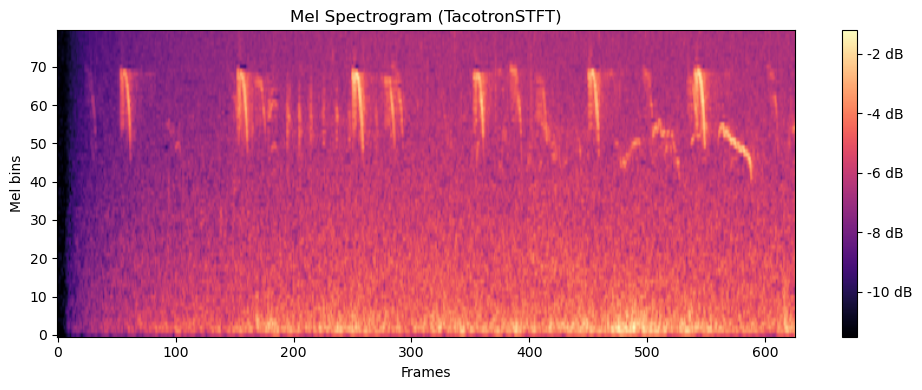

In [28]:
plt.figure(figsize=(10, 4))
plt.imshow(spectro.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title('Mel Spectrogram (TacotronSTFT)')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

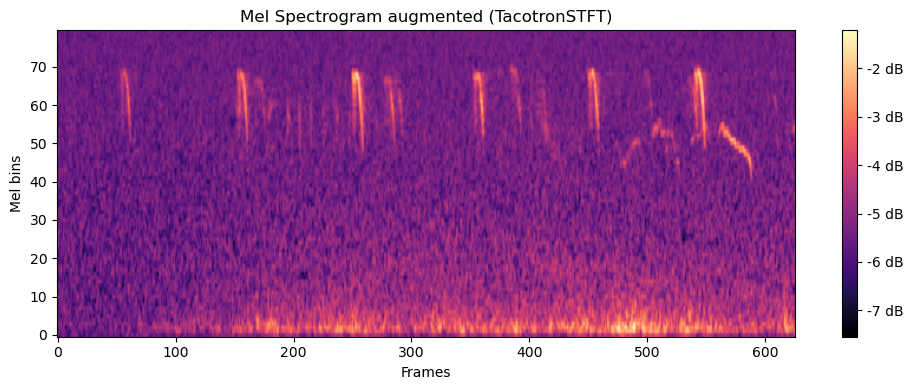

In [29]:
plt.figure(figsize=(10, 4))
plt.imshow(spectro_augmented.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title('Mel Spectrogram augmented (TacotronSTFT)')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [30]:

import torch

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load EfficientNet with pretrained weights
        self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

        # Replace first conv to accept 1-channel input
        old_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias is not None,
        )
        with torch.no_grad():
            new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
        self.model.features[0][0] = new_conv

       
        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),  
            #nn.BatchNorm1d(in_features),
            nn.LayerNorm(in_features),
            nn.Linear(in_features, num_classes)
        )
        #self.model.classifier[1] = nn.Linear(in_features, num_classes)
    def forward(self, x):
        # Ensure input has 4 dimensions (batch_size, channels, height, width)
        if x.dim() == 2:
            x = x.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        elif x.dim() == 3:
            x = x.unsqueeze(1) # Add channel dimension (assuming batch is already there)

        return self.model(x)   

    
model = CustomEfficientNet(num_classes=182)
model.eval()
output = model(spectro)  
output3=model(output_tacrotron)
print('classifier output: ',output.shape)
print(50*"#")
print(model)
print(50*"#")
del model


classifier output:  torch.Size([1, 182])
##################################################
CustomEfficientNet(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_

# BirdNetFFT
Ici nous accolons notre classe Tachrotron et le réseau EfficientNet
Il est possible de dégeler ou non certaines couches


In [32]:
import torch
import torch.nn as nn

def inspect_model_layers(model,print_all=False):
    if print_all:
        for name, param in model.named_parameters():
            print(f"{name:60} | requires_grad = {param.requires_grad}")
        
    else:
        print("\nTrainable layers:")
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(f"  {name}")

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(f"Total parameters:     {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters:    {frozen_params:,}")



class BirdNetFFT(nn.Module):
    def __init__(self, num_classes,mel_trainable=True,efficient_trainable=True,num_features=[7,8],fft_t=True,win_l=True):
        super().__init__()

        self.spectro_layer=TacotronSTFT(mel_trainable=mel_trainable,fft_learnable=fft_t,learn_win=win_l)

        self.model = CustomEfficientNet(num_classes=num_classes)

        for param in self.model.model.parameters():
            param.requires_grad = False
            
        if efficient_trainable:
            assert type(num_features) is list, "features must be a list"
            for feature in num_features:
                
                for param in self.model.model.features[feature].parameters():
                    param.requires_grad = True

        # === Always Unfreeze the classifier head ===
        for param in self.model.model.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        
        x=self.spectro_layer(x)
        
        return self.model(x)
    
audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"
audio_file_test=f"{audio_input_folder}/zitcis1/XC124995.ogg"
audio_file_test=f"{audio_input_folder}/zitcis1/XC127906.ogg"

assert os.path.exists(audio_file_test)

audio_torch_spectro=get_audio_data(audio_raw_file=audio_file_test)

audio_torch_augmented=get_audio_data_augmented(audio_raw_file=audio_file_test,apply_augmentation=True)

audio_torch_spectro = audio_torch_spectro
audio_torch_augmented = audio_torch_augmented


bird_model = BirdNetFFT(num_classes=182)

bird_model.eval()

output_bird=bird_model(audio_torch_spectro)

output_bird_aug=bird_model(audio_torch_augmented)

print(torch.argmax(output_bird).detach().numpy())

inspect_model_layers(bird_model,print_all=False)

del bird_model


179

Trainable layers:
  spectro_layer.mel_basis
  spectro_layer.stft_fn.forward_basis
  spectro_layer.stft_fn.inverse_basis
  spectro_layer.stft_fn.fft_window
  model.model.features.7.0.block.0.0.weight
  model.model.features.7.0.block.0.1.weight
  model.model.features.7.0.block.0.1.bias
  model.model.features.7.0.block.1.0.weight
  model.model.features.7.0.block.1.1.weight
  model.model.features.7.0.block.1.1.bias
  model.model.features.7.0.block.2.fc1.weight
  model.model.features.7.0.block.2.fc1.bias
  model.model.features.7.0.block.2.fc2.weight
  model.model.features.7.0.block.2.fc2.bias
  model.model.features.7.0.block.3.0.weight
  model.model.features.7.0.block.3.1.weight
  model.model.features.7.0.block.3.1.bias
  model.model.features.8.0.weight
  model.model.features.8.1.weight
  model.model.features.8.1.bias
  model.model.classifier.1.weight
  model.model.classifier.1.bias
  model.model.classifier.2.weight
  model.model.classifier.2.bias
Total parameters:     6,385,986
Traina

# test of gradient

Ici nous vérifions que la couche mel_basis est bien entraînable

In [33]:
model_b = BirdNetFFT(num_classes=182,mel_trainable=True)
model_b.eval()
audio_file_test=f"{audio_input_folder}/zitcis1/XC655341.ogg"
assert os.path.exists(audio_file_test)

audio_torch_spectro=get_audio_data(audio_raw_file=audio_file_test)
print(audio_torch_spectro.shape)

y = model_b(audio_torch_spectro)  # forward

loss = y.sum()
loss.backward()

assert model_b.spectro_layer.mel_basis.grad is not None,'layer mel_basis shall be trainable'

del model_b

model_b = BirdNetFFT(num_classes=182,mel_trainable=False)
model_b.eval()

y = model_b(audio_torch_spectro)  # forward

loss = y.sum()
loss.backward()

assert model_b.spectro_layer.mel_basis.grad is None,'layer mel_basis shall not be  trainable'

del model_b


torch.Size([1, 160000])


# dataset building

Le dataset renvoie le spectrogramm et le label (l'index de l'espece d'oiseau) associé

In [ ]:

root_folder='/home/christophe/birdclef'
folder_store_audio=root_folder+audio_input_folder
label_list = sorted(os.listdir(os.path.join(root_folder, 'train_audio')))
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

def get_id_from_label(dict_label:dict,label:str):
    return dict_label[label]

id_test=get_id_from_label(label2id,'asikoe2')
assert id_test==4
print('asikoe2 index: ',id_test)
id_test=get_id_from_label(label2id,'barswa')
assert id_test==9
print('barswa index: ',id_test)

asikoe2 index:  4
barswa index:  9


In [ ]:
id2label

to be tested

from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    with autocast():
        outputs = model_b(inputs)
        loss = criterion(outputs, labels)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()


In [ ]:
import os
import torch
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split


class BirdAudioDataset(Dataset):
    def __init__(self, root_dir, audio_extensions=(".ogg",),data_augment=False,rate_aug=0.1):
        self.root_dir = root_dir
        self.audio_extensions = audio_extensions
        self.samples = []
        self.data_augment=data_augment
        self.rate_augmentation=rate_aug
        # Walk through each subdirectory
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if not os.path.isdir(label_path):
                continue
            for fname in os.listdir(label_path):
                if fname.lower().endswith(audio_extensions):
                    if self.data_augment: # we don't augment all frames
                        if random.random()<self.rate_augmentation:
                            fpath = os.path.join(label_path, fname)
                            self.samples.append((fpath, label))
                    else:
                        fpath = os.path.join(label_path, fname)
                        self.samples.append((fpath, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]

        #input_model=get_audio_data(audio_path)
        input_model=get_audio_data_augmented(audio_path,apply_augmentation=self.data_augment)
        id_label=get_id_from_label(dict_label=label2id,label=label)
        return input_model, id_label
    

In [ ]:
import os
import torch
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split


class BirdAudioDatasetV2(Dataset):
    def __init__(self, root_dir, audio_extensions=(".ogg",)):
        self.root_dir = root_dir
        self.audio_extensions = audio_extensions
        self.samples = []

        # Walk through each subdirectory
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if not os.path.isdir(label_path):
                continue
            for fname in os.listdir(label_path):
                if fname.lower().endswith(audio_extensions):

                    fpath = os.path.join(label_path, fname)
                    self.samples.append((fpath, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]

        input_model=get_audio_data(audio_path)

        id_label=get_id_from_label(dict_label=label2id,label=label)
        return input_model, id_label
    

# Entrainement du modèle

a faire: creer plusieurs configs avec les couches entraianbles ou pas

logger les configs dans mlflow

https://huggingface.co/ilyassmoummad/ProtoCLR

In [ ]:
# those configs specify parameters of interrest used in training
# rate_augmentaion must be removed
class train_config_1:
    tachrotron_trainable=True
    efficient_net_trainable=True
    layers_unfreezed_number=[7,8]
    name='full_train'
    data_augmentation=False
    rate_augmentation=0.001

class train_config_2:
    tachrotron_trainable=False
    efficient_net_trainable=True
    layers_unfreezed_number=[7,8]
    name='partial_train'
    data_augmentation=True
    rate_augmentation=0.1

# both data augmenation + fft learnable

class train_config_test:
    tachrotron_trainable=True
    efficient_net_trainable=True
    layers_unfreezed_number=[8]
    name='test_train'
    data_augmentation=True
    rate_augmentation=0.1


In [ ]:
import time
import sys
import joblib
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import mlflow
import mlflow.pytorch

assert torch.cuda.is_available(), "GPU not available"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device available: ',device)
config_t=train_config_2()
print('Train configuration: ',config_t.name)
data_augment=config_t.data_augmentation
rate_aug=config_t.rate_augmentation # useless with dataset v2
# Load entire dataset
dataset = BirdAudioDatasetV2(root_dir="/home/christophe/birdclef/train_audio")
print('raw dataset: ',len(dataset))

if data_augment:
    dataset_augmented=BirdAudioDatasetV2("/home/christophe/birdclef/train_audio_aug")
    print('augmented dataset: ',len(dataset_augmented))
    full_dataset = ConcatDataset([dataset, dataset_augmented])
else:
    full_dataset=dataset
    

total_size = len(full_dataset)

train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size  = total_size - train_size - valid_size  

# dataset is reproducible
generator = torch.Generator().manual_seed(42)
train_set, valid_set, test_set = random_split(full_dataset, [train_size, valid_size, test_size], generator=generator)

# ram usage is not too high so we can use large batch size
batch_size=32 
# persistent_workers=True ???
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size,num_workers=4, pin_memory=True)

num_epochs = 6

eval_rate=2

start_time=time.time()
model_retrieve_config1=False

if model_retrieve_config1:
    experiment_name = "birdnet_training"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    #last_run_id='a51e5c078c874f7391583a22d7204f86' # best model so far (see in mlflow ui)
    latest_run_id = runs.iloc[0].run_id # last run
    # Load model from that run
    model_b = mlflow.pytorch.load_model(f"runs:/{latest_run_id}/model_bird_best_val_accu")
    sys.exit('implement loading the config??')
else:
    model_b = BirdNetFFT(num_classes=182,mel_trainable=config_t.tachrotron_trainable,efficient_trainable=config_t.efficient_net_trainable
                     ,num_features=config_t.layers_unfreezed_number).to(device)

learning_rate=1e-2
optimizer = optim.Adam(model_b.parameters(), lr=learning_rate) 
step_size=3
gamma=0.95
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

file_name_accu='best_val_train_accuracy.joblib'
assert os.path.exists(file_name_accu), "missing file that stores accuracy"
best_val_accuracy=joblib.load(filename=file_name_accu)
print('Previous best validation  accuracy: ',best_val_accuracy)


mlflow.set_experiment("birdnet_training")
val_indicator=0
with mlflow.start_run():
    mlflow.log_param('num_epochs',num_epochs)
    mlflow.log_param('learning_rate',learning_rate)
    mlflow.log_param('config_train',config_t.name)
    mlflow.log_param('efficient_trainable',config_t.efficient_net_trainable)
    mlflow.log_param('mel_basis_trainable',config_t.tachrotron_trainable)
    mlflow.log_param('efficent_layers_unfreezed',config_t.layers_unfreezed_number)
    mlflow.log_param('step_size_scheduler',step_size)
    mlflow.log_param('scheduler_gamma',gamma)
    mlflow.log_param('dataset_size',total_size)
    mlflow.log_param('data_augmented',config_t.data_augmentation)
    if data_augment:
        mlflow.log_param('rate_augmentation',config_t.rate_augmentation)
    
    
    for epoch in range(num_epochs):
        
        model_b.train() 
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            
            labels = labels.to(device)

            optimizer.zero_grad()  
            
            outputs = model_b(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  
            optimizer.step()  

            running_train_loss += loss.item() * inputs.size(0) # Accumulate batch loss
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            correct_train_predictions += (predicted == labels).sum().item()
            
        epoch_train_loss = running_train_loss / total_train_samples
        epoch_train_accuracy = 100 * correct_train_predictions / total_train_samples
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%")
        mlflow.log_metric("epoch_train_loss", epoch_train_loss, step=epoch)
        mlflow.log_metric('epoch_train_accuracy',epoch_train_accuracy,step=epoch)
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}: learning rate = {current_lr}")
        mlflow.log_metric("learning_rate", current_lr, step=epoch)
        if epoch%eval_rate==0:
            
            # Validation Phase
            model_b.eval()  # Set model to evaluation mode
            running_valid_loss = 0.0
            correct_valid_predictions = 0
            total_valid_samples = 0

            with torch.no_grad():  # Disable gradient calculation for validation
                for inputs, labels in valid_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model_b(inputs)
                    loss = criterion(outputs, labels)

                    running_valid_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total_valid_samples += labels.size(0)
                    correct_valid_predictions += (predicted == labels).sum().item()

            epoch_valid_loss = running_valid_loss / total_valid_samples
            epoch_valid_accuracy = 100 * correct_valid_predictions / total_valid_samples
            print(f"Epoch {epoch+1}/{num_epochs} - Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.2f}%")
            mlflow.log_metric("valid_loss",epoch_valid_loss,step=val_indicator)
            mlflow.log_metric('valid_accuracy',epoch_valid_accuracy,step=val_indicator)
            if epoch_valid_accuracy>best_val_accuracy:
                best_val_accuracy=epoch_valid_accuracy
                joblib.dump(value=best_val_accuracy,filename=file_name_accu)
                mlflow.pytorch.log_model(model_b, "model_bird_best_val_accu")
            val_indicator+=1
    train_time=(time.time()-start_time)/num_epochs
    print(f'Train time per epoch: {train_time:.3f} seconds')
    mlflow.log_metric("train_time_per_epoch",train_time)
    print("Training complete!")
    mlflow.end_run()


Device available:  cuda
Train configuration:  partial_train
raw dataset:  24459
augmented dataset:  910
Previous best validation  accuracy:  32.851690294438384
Epoch 1/6 - Train Loss: 4.2588, Train Acc: 16.65%
Epoch 1: learning rate = 0.01
Epoch 1/6 - Valid Loss: 3.0564, Valid Acc: 29.62%
Epoch 2/6 - Train Loss: 2.9424, Train Acc: 30.75%
Epoch 2: learning rate = 0.01
Epoch 3/6 - Train Loss: 2.6569, Train Acc: 35.89%
Epoch 3: learning rate = 0.0095


2025/07/11 11:32:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 3/6 - Valid Loss: 2.5276, Valid Acc: 41.13%


2025/07/11 11:32:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 4/6 - Train Loss: 2.4608, Train Acc: 40.37%
Epoch 4: learning rate = 0.0095
Epoch 5/6 - Train Loss: 2.3134, Train Acc: 43.19%
Epoch 5: learning rate = 0.0095


2025/07/11 11:35:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch 5/6 - Valid Loss: 2.4917, Valid Acc: 43.31%


2025/07/11 11:35:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 6/6 - Train Loss: 2.2094, Train Acc: 45.47%
Epoch 6: learning rate = 0.009025
Train time per epoch: 96.866 seconds
Training complete!


# dummy baseline

In [ ]:
from sklearn.metrics import accuracy_score
num_classes = 182
num_samples = 25000 # same as birdclef dataset size
y_true = np.random.randint(0, num_classes, size=num_samples)

# Random predictions (uniform across all classes)
y_pred = np.random.randint(0, num_classes, size=num_samples)

# Compute accuracy
accuracy_dummy = accuracy_score(y_true, y_pred)

print(f"Dummy classifier accuracy percenatge on {num_samples} samples: {accuracy_dummy*100:.4f}")


Dummy classifier accuracy on 25000 samples: 0.5960


# métriques sur le jeu de test

Logging to MLflow run: 1addcdd335914ad6a9cea8a0085945e7

Evaluating on Test Set...
run_id of the loaded model:  a51e5c078c874f7391583a22d7204f86
Test Loss: 3.0610, Test Accuracy: 32.70%


/home/christophe/miniforge3/envs/birdgpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/christophe/miniforge3/envs/birdgpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/christophe/miniforge3/envs/birdgpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

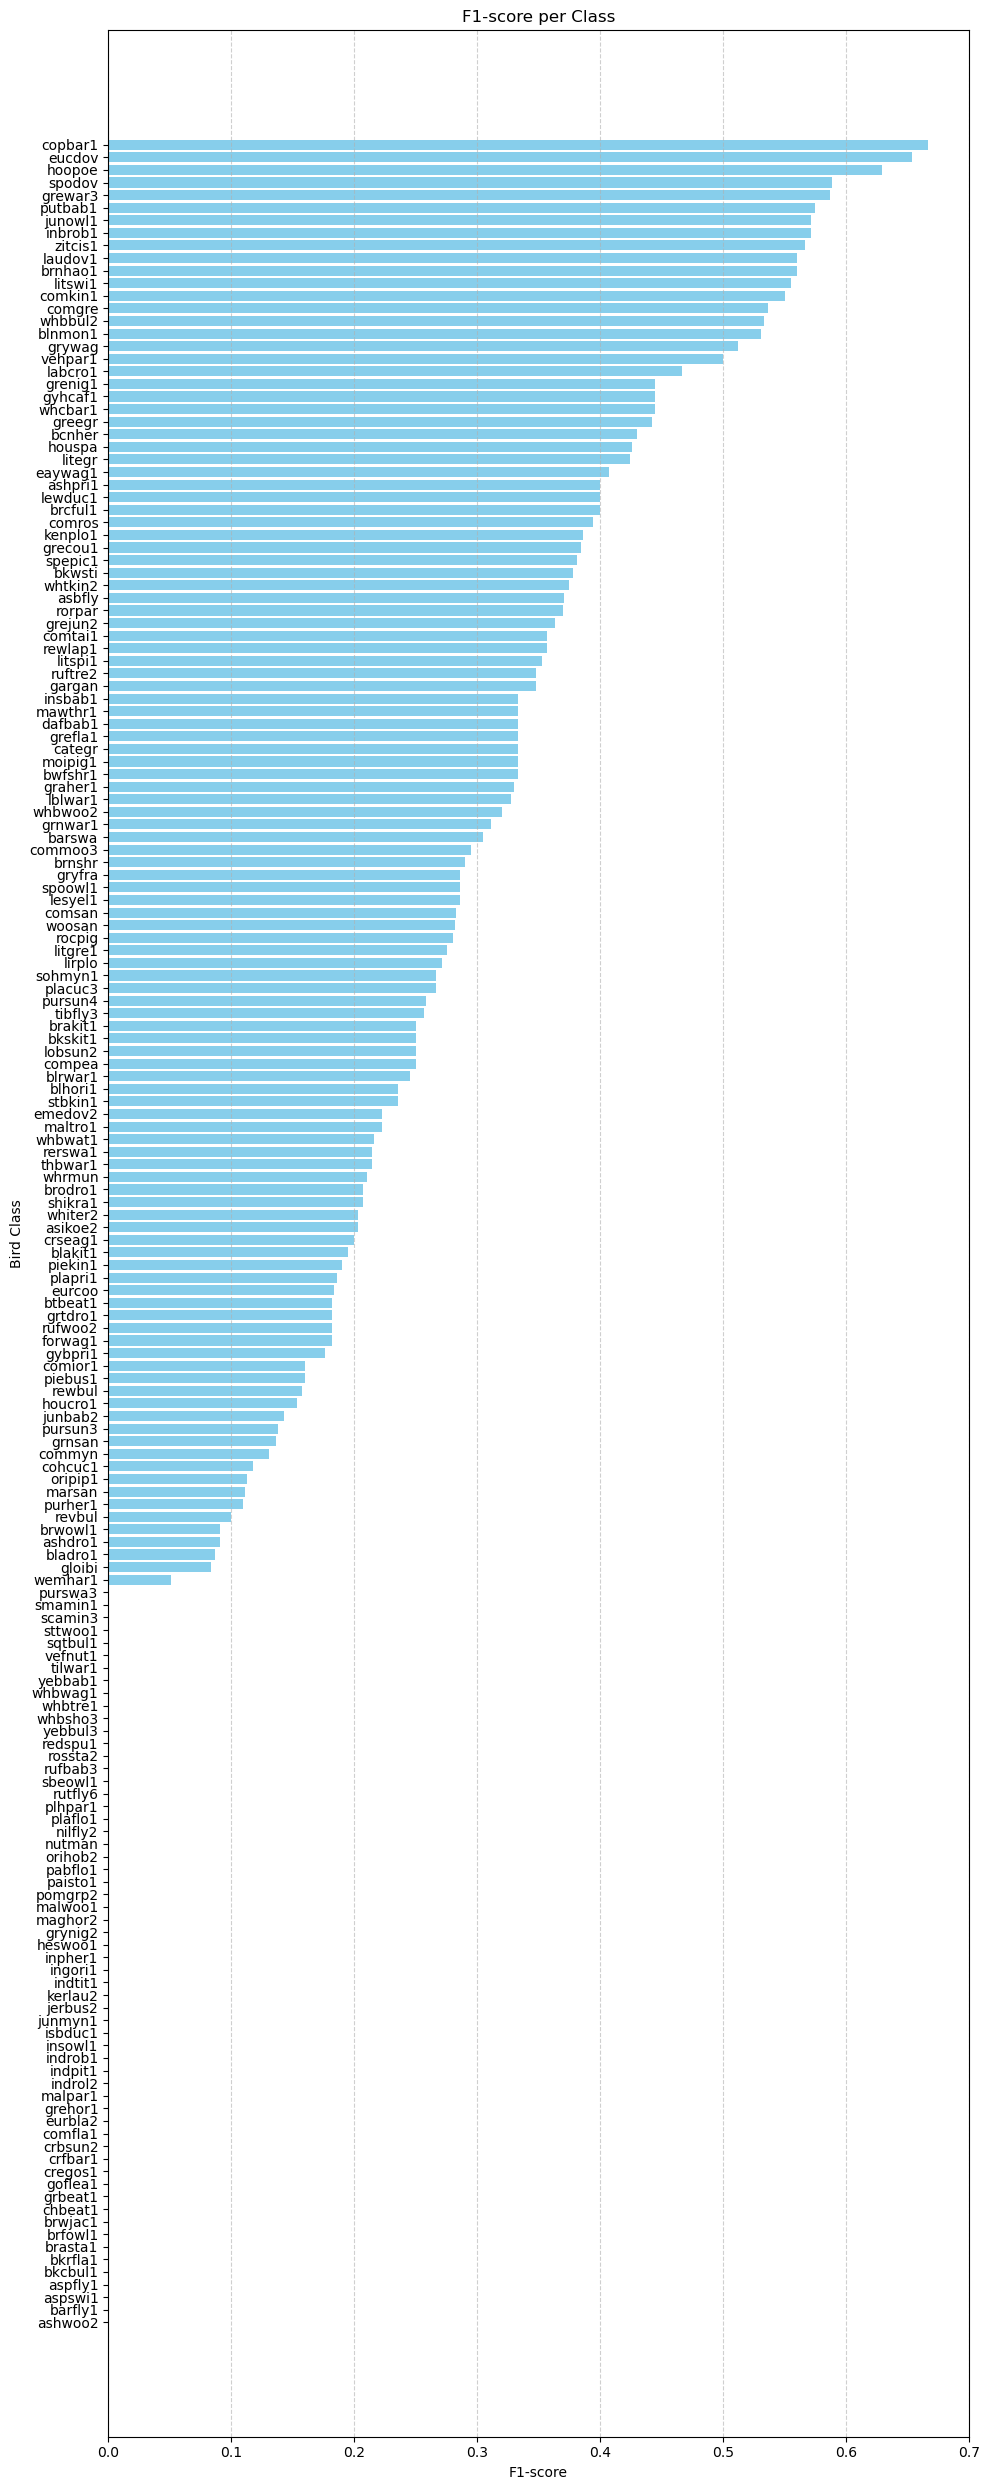

In [ ]:
import mlflow
import torch
import pandas as pd
from sklearn.metrics import classification_report
from datetime import datetime
import os

# === Setup MLflow Experiment ===
test_experiment_name = "birdnet_testing"
mlflow.set_experiment(test_experiment_name)

# last_run_id='a51e5c078c874f7391583a22d7204f86' # best model so far

with mlflow.start_run() as run:
    run_id = run.info.run_id
    print("Logging to MLflow run:", run_id)

    # === Load Model ===
    print("\nEvaluating on Test Set...")
    experiment_name = "birdnet_training"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    latest_run_id = runs.iloc[0].run_id
    print('run_id of the loaded model: ', latest_run_id)
    model_loaded_tag=f"runs:/{latest_run_id}/model_bird_best_val_accu"
    mlflow.log_param('Model loaded run_id',model_loaded_tag)
    model_b = mlflow.pytorch.load_model(model_loaded_tag)
    model_b.to(device)
    model_b.eval()

    # === Test Loop ===
    correct_test_predictions = 0
    total_test_samples = 0
    running_test_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    mlflow.log_param('loss_used',criterion.__class__.__name__)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_b(inputs)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)

            total_test_samples += labels.size(0)
            correct_test_predictions += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # === Metrics ===
    test_loss = running_test_loss / total_test_samples
    test_accuracy = 100 * correct_test_predictions / total_test_samples
    now = datetime.now()
    timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # === Log Metrics to MLflow ===
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)

    # Log timestamp as tag or param
    mlflow.set_tag("timestamp", timestamp)

    # === Classification Report ===
    report_classification = classification_report(all_labels, all_preds, digits=2, output_dict=True)
    report_df = pd.DataFrame(report_classification).transpose()

    # Map class names
    id_to_name_str = {str(k): v for k, v in id2label.items()}
    report_df['class_name'] = report_df.index.map(id_to_name_str)

    cols = ['class_name'] + [col for col in report_df.columns if col != 'class_name']
    report_df = report_df[cols]

    # Save and log as artifact
    output_dir = "mlflow_artifacts"
    os.makedirs(output_dir, exist_ok=True)
    report_path = os.path.join(output_dir, f"classification_report_{timestamp}.csv")
    report_df.to_csv(report_path, index=True)

    mlflow.log_artifact(report_path)

    f1_df=report_df[['class_name','f1-score']]
    f1_df_clean = f1_df[~f1_df['class_name'].isna()].copy()
    f1_df_sorted = f1_df_clean.sort_values(by='f1-score', ascending=True)
    plt.figure(figsize=(10, 25))  # Adjust height for many classes
    plt.barh(f1_df_sorted['class_name'], f1_df_sorted['f1-score'], color='skyblue')
    plt.xlabel('F1-score')
    plt.ylabel('Bird Class')
    plt.title('F1-score per Class')
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    save_f1_plot=f'f1_scores_per_class_{timestamp}.png'
    plt.savefig(save_f1_plot)
    mlflow.log_artifact(save_f1_plot)
    


# OLDY CODE

In [ ]:
import mlflow
import torch
from sklearn.metrics import classification_report,confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt

print("\nEvaluating on Test Set...")
experiment_name = "birdnet_training"
experiment = mlflow.get_experiment_by_name(experiment_name)
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
latest_run_id = runs.iloc[0].run_id
print('run_id of the loaded model: ',latest_run_id)

model_b = mlflow.pytorch.load_model(f"runs:/{latest_run_id}/model_bird_best_val_accu")

model_b.to(device)
model_b.eval()
correct_test_predictions = 0
total_test_samples = 0
running_test_loss = 0.0
criterion = nn.CrossEntropyLoss()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_b(inputs)
        loss = criterion(outputs, labels)

        running_test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_test_samples += labels.size(0)
        correct_test_predictions += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = running_test_loss / total_test_samples
test_accuracy = 100 * correct_test_predictions / total_test_samples
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
print("\nClassification Report:")
report_classification=classification_report(all_labels, all_preds, digits=2,output_dict=True)
report_df = pd.DataFrame(report_classification).transpose()

#id_to_name=id2label
id_to_name_str = {str(k): v for k, v in id2label.items()}

report_df['class_name'] = report_df.index.map(id_to_name_str)

# reassign columns
cols = ['class_name'] + [col for col in report_df.columns if col != 'class_name']
report_df = report_df[cols]

now = datetime.now()
timestamp = now.strftime("%B %d %H:%M")
report_df.to_csv(f"classification_report_{timestamp}.csv", index=True)

f1_df=report_df[['class_name','f1-score']]
f1_df_clean = f1_df[~f1_df['class_name'].isna()].copy()
f1_df_sorted = f1_df_clean.sort_values(by='f1-score', ascending=True)
plt.figure(figsize=(10, 25))  # Adjust height for many classes
plt.barh(f1_df_sorted['class_name'], f1_df_sorted['f1-score'], color='skyblue')
plt.xlabel('F1-score')
plt.ylabel('Bird Class')
plt.title('F1-score per Class')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
save_f1_plot=f'f1_scores_per_class_{timestamp}.png'
plt.savefig(save_f1_plot)
mlflow.log_artifact(save_f1_plot)



Evaluating on Test Set...
e3f015e27513419c94e2370cdcce8f93
Test Loss: 3.5225, Test Accuracy: 22.62%

Classification Report:


/home/christophe/miniforge3/envs/birdgpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/christophe/miniforge3/envs/birdgpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/christophe/miniforge3/envs/birdgpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [31]:
report_df

class_name  precision    recall  f1-score      support
0                asbfly   1.000000  0.200000  0.333333    15.000000
1               ashdro1   0.222222  0.117647  0.153846    17.000000
2               ashpri1   0.250000  0.055556  0.090909    18.000000
3               ashwoo2   0.000000  0.000000  0.000000    12.000000
4               asikoe2   0.154930  0.305556  0.205607    36.000000
...                 ...        ...       ...       ...          ...
180             yebbul3   0.000000  0.000000  0.000000     3.000000
181             zitcis1   0.459016  0.444444  0.451613    63.000000
accuracy            NaN   0.226158  0.226158  0.226158     0.226158
macro avg           NaN   0.162941  0.104514  0.103190  3670.000000
weighted avg        NaN   0.247624  0.226158  0.203466  3670.000000

[176 rows x 5 columns]

In [33]:
f1_df=report_df[['class_name','f1-score']]
f1_df

class_name  f1-score
0                asbfly  0.333333
1               ashdro1  0.153846
2               ashpri1  0.090909
3               ashwoo2  0.000000
4               asikoe2  0.205607
...                 ...       ...
180             yebbul3  0.000000
181             zitcis1  0.451613
accuracy            NaN  0.226158
macro avg           NaN  0.103190
weighted avg        NaN  0.203466

[176 rows x 2 columns]

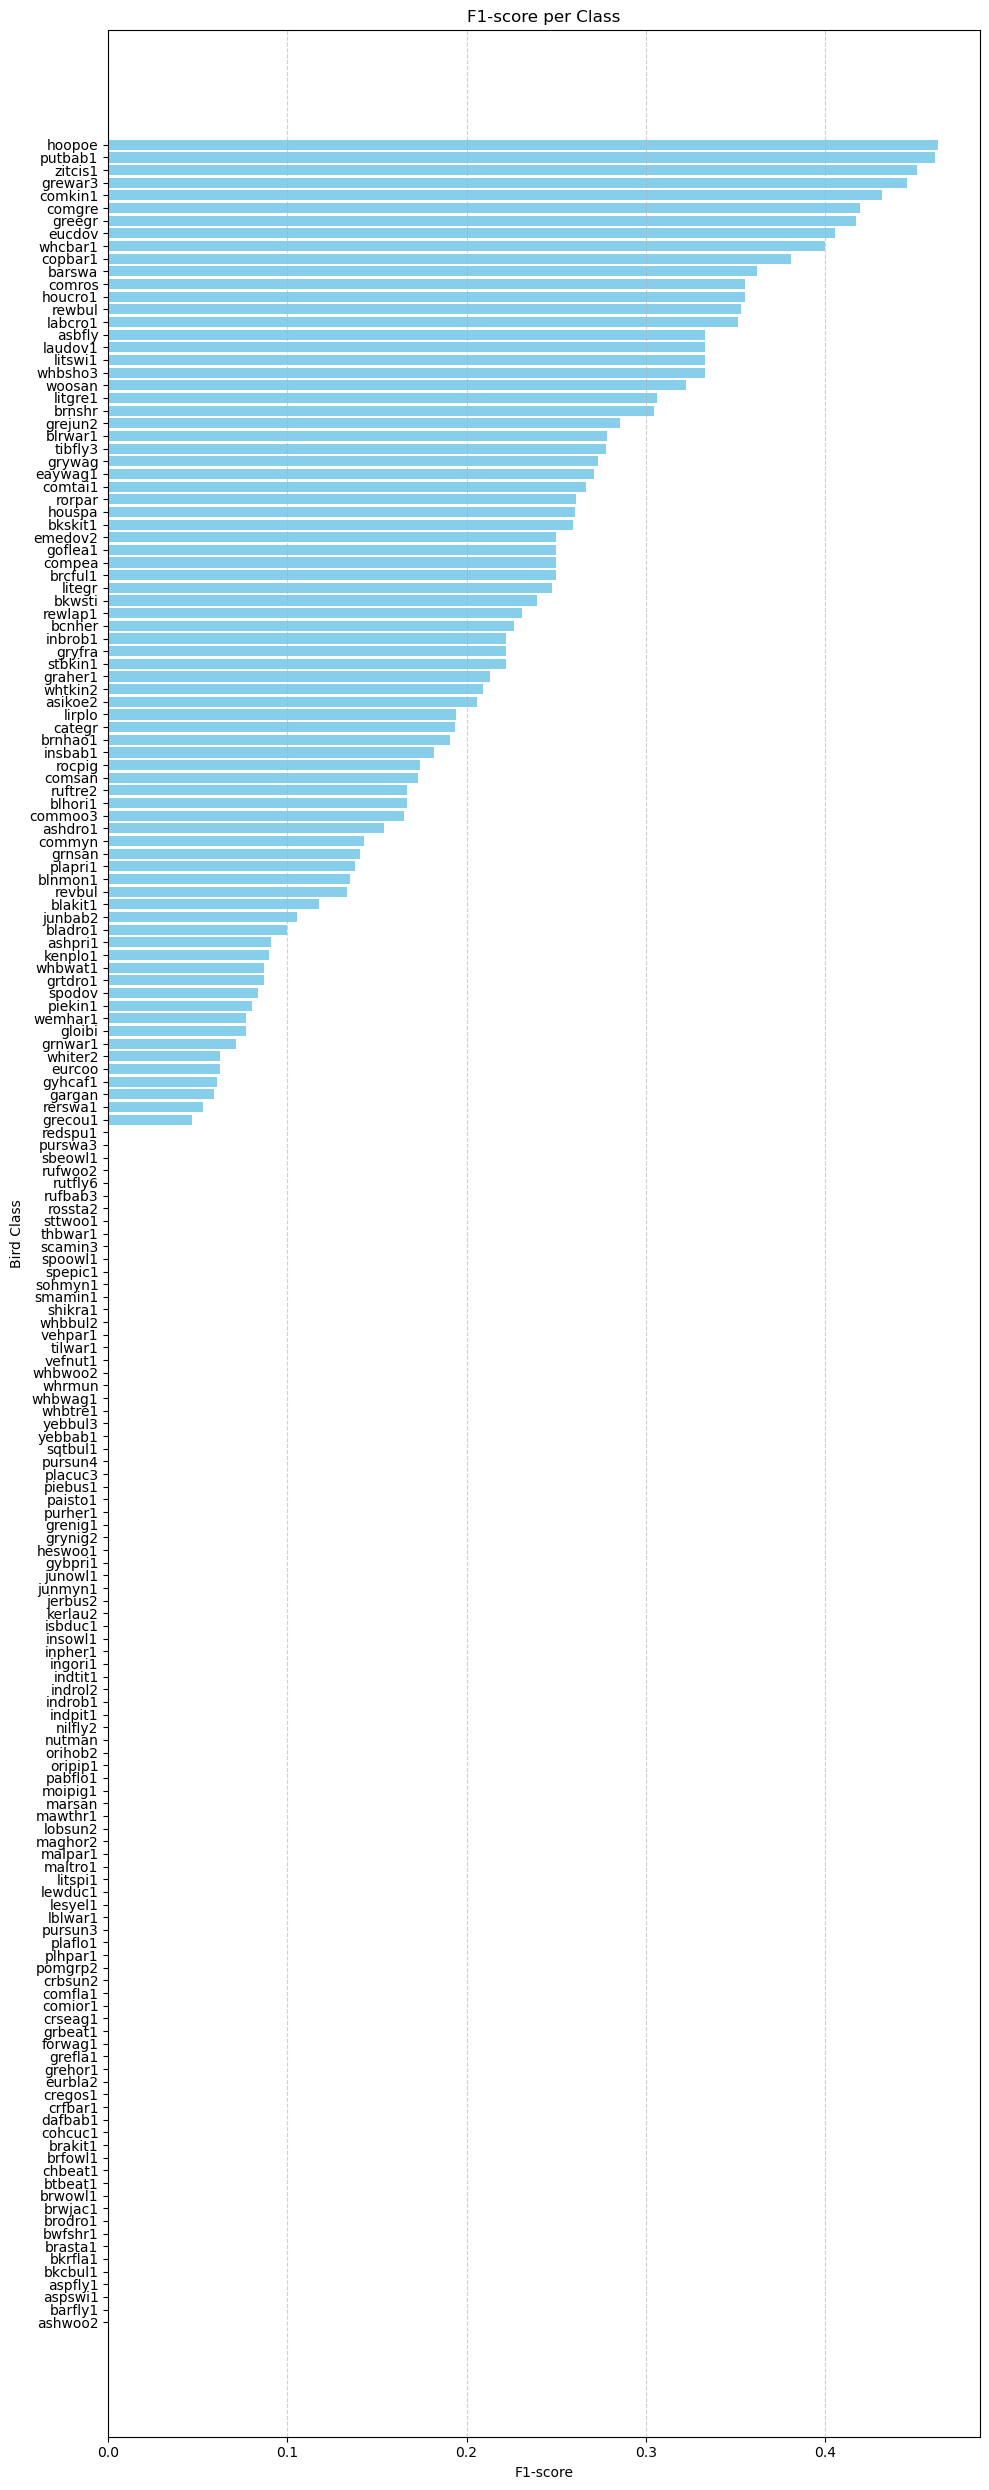

In [ ]:
import matplotlib.pyplot as plt

f1_df_clean = f1_df[~f1_df['class_name'].isna()].copy()


f1_df_sorted = f1_df_clean.sort_values(by='f1-score', ascending=True)
plt.figure(figsize=(10, 25))  # Adjust height for many classes
plt.barh(f1_df_sorted['class_name'], f1_df_sorted['f1-score'], color='skyblue')
plt.xlabel('F1-score')
plt.ylabel('Bird Class')
plt.title('F1-score per Class')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()



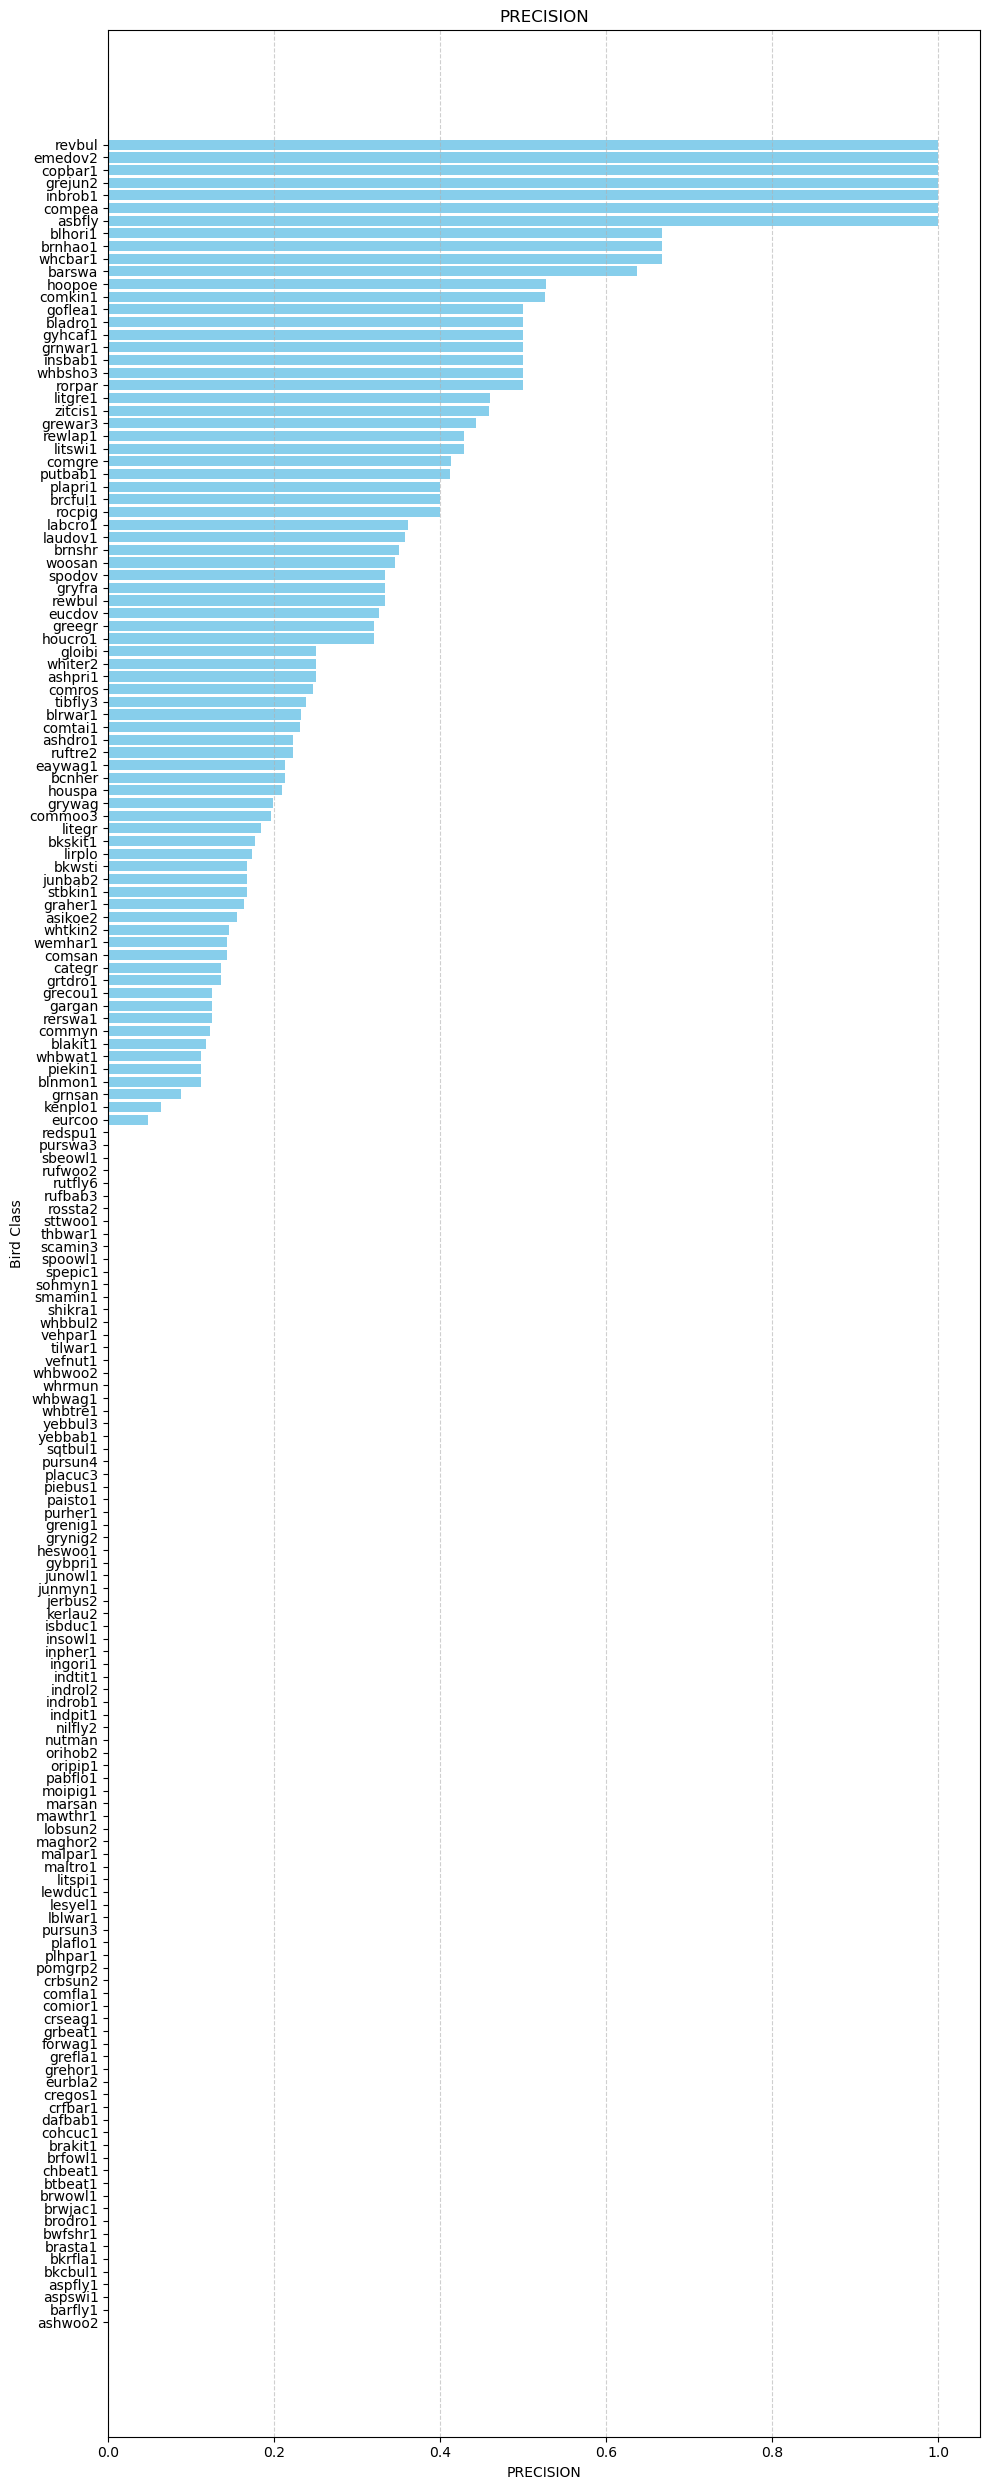

In [38]:

import matplotlib.pyplot as plt
precision_df=report_df[['class_name','precision']]


pres_df_clean = precision_df[~precision_df['class_name'].isna()].copy()


pres_df_sorted = pres_df_clean.sort_values(by='precision', ascending=True)
plt.figure(figsize=(10, 25))  # Adjust height for many classes
plt.barh(pres_df_sorted['class_name'], pres_df_sorted['precision'], color='skyblue')
plt.xlabel('PRECISION')
plt.ylabel('Bird Class')
plt.title('PRECISION')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


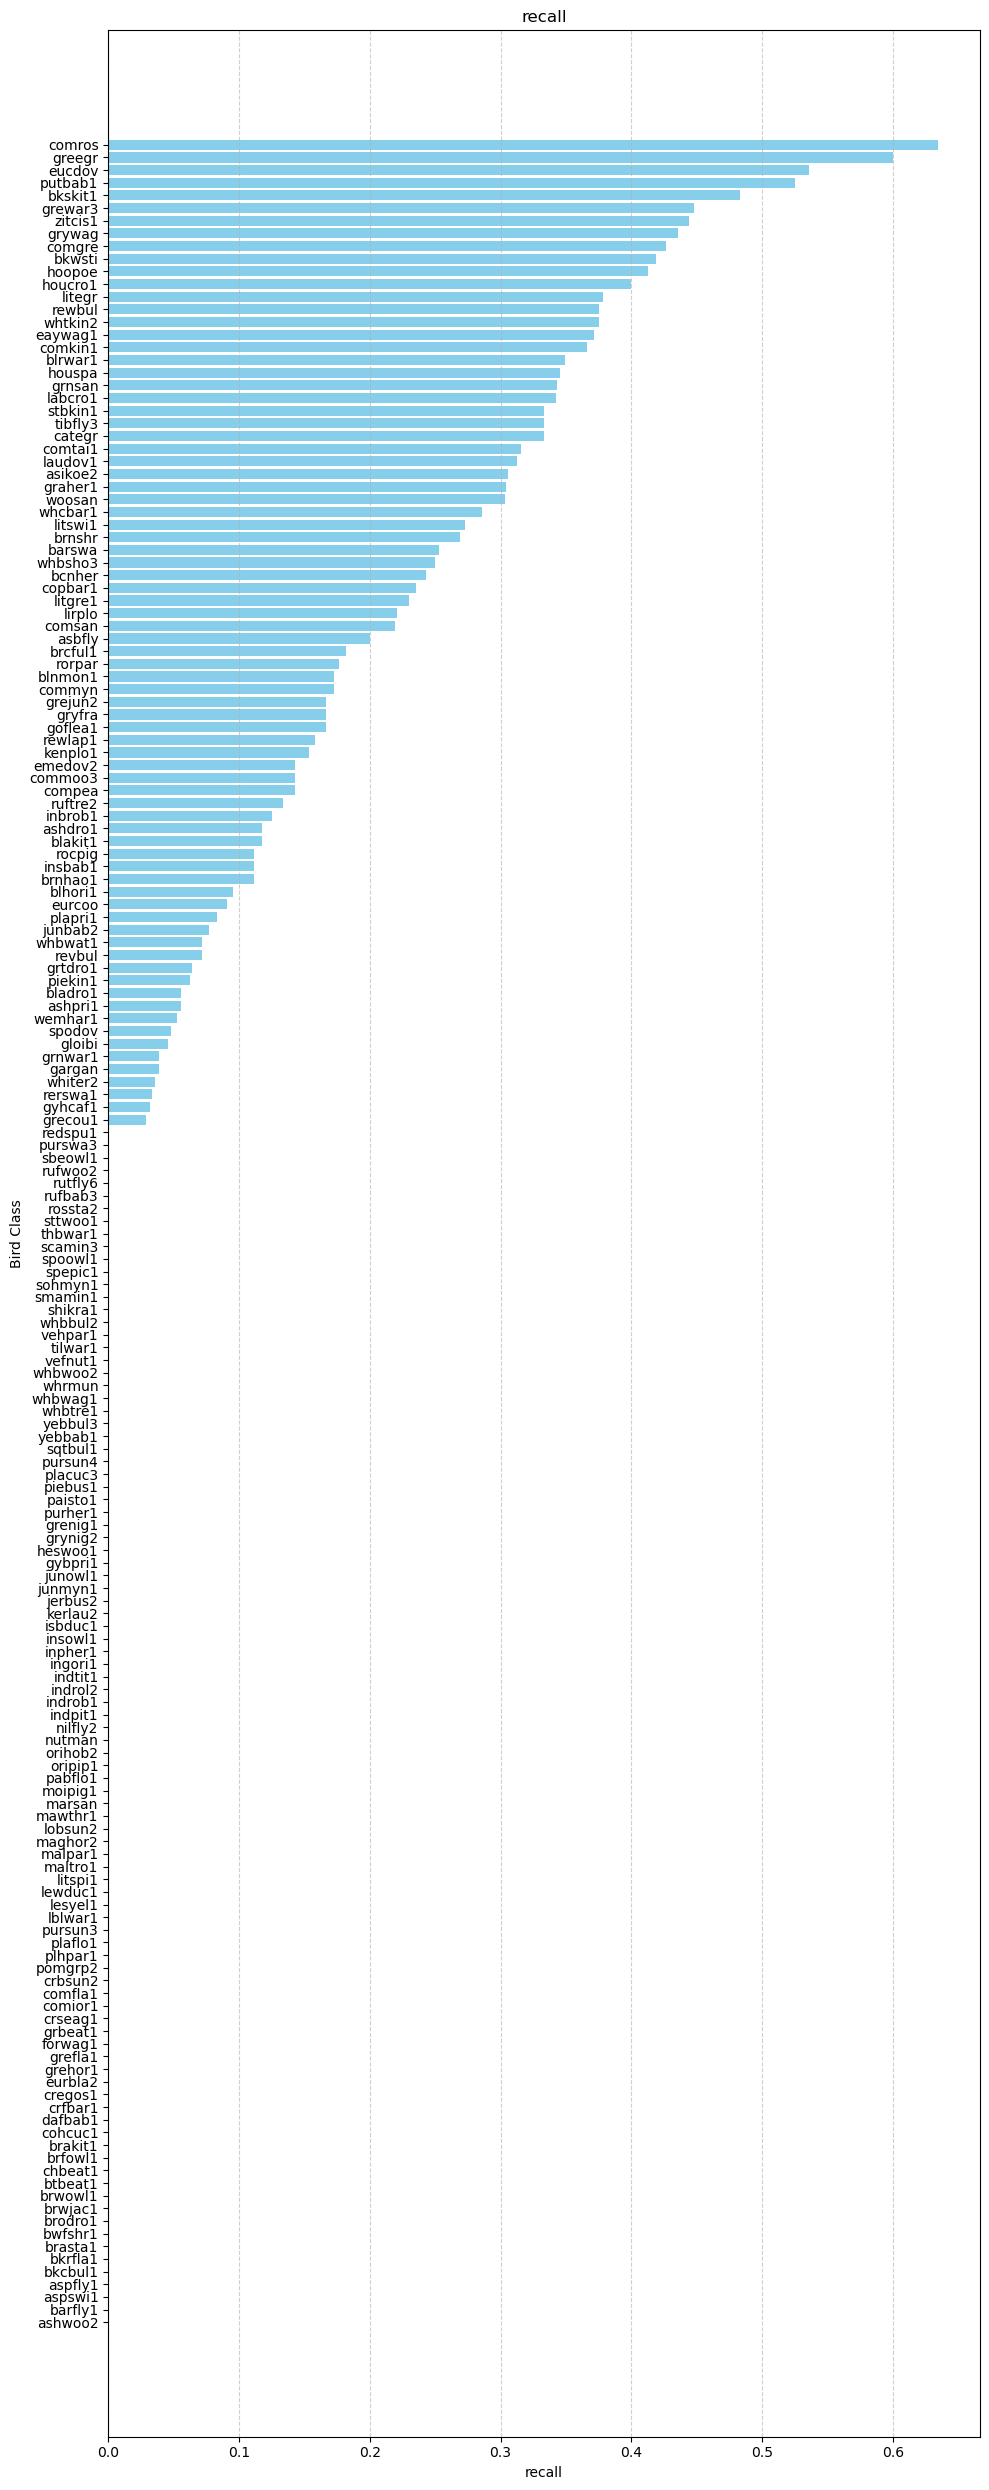

In [39]:

import matplotlib.pyplot as plt
recall_df=report_df[['class_name','recall']]

pres_df_clean = recall_df[~recall_df['class_name'].isna()].copy()

pres_df_sorted = pres_df_clean.sort_values(by='recall', ascending=True)
plt.figure(figsize=(10, 25))  # Adjust height for many classes
plt.barh(pres_df_sorted['class_name'], pres_df_sorted['recall'], color='skyblue')
plt.xlabel('recall')
plt.ylabel('Bird Class')
plt.title('recall')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


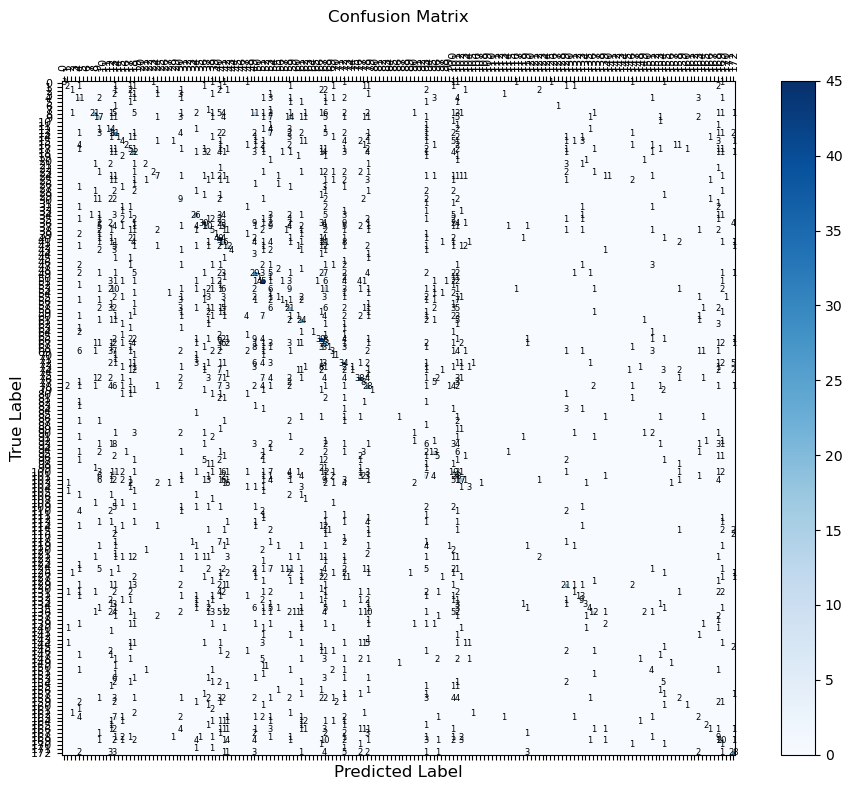

In [ ]:

conf_matrix = confusion_matrix(all_labels, all_preds)

num_classes = conf_matrix.shape[0]

class_names = list(range(num_classes))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add colorbar
fig.colorbar(cax)

# Set axis labels
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)

# Tick marks and class names
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(class_names, rotation=90, fontsize=8)
ax.set_yticklabels(class_names, fontsize=8)

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        value = conf_matrix[i, j]
        if value > 0:
            ax.text(j, i, str(value), va='center', ha='center', fontsize=6, color='black')

plt.title("Confusion Matrix", pad=20)
plt.tight_layout()
plt.show()

# check spectrogramm

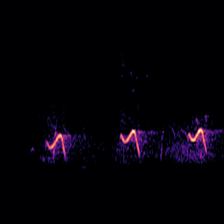

In [6]:

custom_p7_spectrograms_for_audio(f"{audio_input_folder}/asikoe2/", "XC138196.ogg",image_output_folder='dummy', preview=True)

retrieve support

In [ ]:
import pandas as pd
report=pd.read_csv('/home/christophe/birdclef/mlflow_artifacts/classification_report_2025-07-09_21-40-00.csv')
peport=report.iloc[:-3]

support=peport['support']


# DATA AUGMENTATION

# GARBAGE CODE BELOW

In [ ]:
meta_data = pd.read_csv(dataset_root_folder+"eBird_Taxonomy_v2021.csv")
birds_of_interest = [
    "Eurasian Coot", #
    "Blyth's Reed Warbler", #
    "Gray Heron", #
    "Greenish Warbler", #
    "Black-crowned Night-Heron", 
    "Rose-ringed Parakeet", #
    "Greater Racket-tailed Drongo", #
    "White-breasted Waterhen", #
    "Gray-headed Canary-Flycatcher", #
    "Great Egret", #
    "Little Egret", #
    "Red-whiskered Bulbul"#
]

print(len(birds_of_interest))
metadata_of_interest = meta_data[meta_data['PRIMARY_COM_NAME'].isin(birds_of_interest)]
print(metadata_of_interest.shape)
metadata_of_interest
def bird_species_from_folder(path):
    if path.endswith('/'):
        path = path[:-1]

    last_folder = os.path.basename(path)
    primary_com_name = metadata_of_interest.loc[metadata_of_interest['SPECIES_CODE'] == last_folder, 'PRIMARY_COM_NAME']
    primary_com_name_str = primary_com_name.iloc[0] if not primary_com_name.empty else ''    
    return f"{primary_com_name_str} ({last_folder})"

species_codes_of_interest = metadata_of_interest['SPECIES_CODE'].tolist()
species_codes_of_interest
# from PIL import Image as pil
# from pkg_resources import parse_version

# if parse_version(pil.__version__)>=parse_version('10.0.0'):
#     Image.ANTIALIAS=Image.LANCZOS

# List everything in the audio input folder
entries = os.listdir(audio_input_folder)

# Filter to get only directories
# subdirectories = [entry for entry in entries if os.path.isdir(os.path.join(audio_input_folder, entry))]
subdirectories = [entry for entry in entries if os.path.isdir(os.path.join(audio_input_folder, entry)) and entry in species_codes_of_interest]

# Sort the directories
subdirectories.sort()

#to start processing at a certain folder offset
subdirectories = subdirectories[start_at_folder_offset:]

folder_count = len(subdirectories)
folders_processed = 0

# Iterate through each sorted directory
total_images = 0
print('27 june first test images will be generated only for 1 folder')

for subdir in subdirectories:
    print('for now no image created')
    break
    subdir_path = os.path.join(audio_input_folder, subdir)
    folders_processed += 1
    print("\n", bird_species_from_folder(subdir_path), folders_processed, "/", folder_count)

    # List files in the current directory (in any order)
    filenames = os.listdir(subdir_path)
    
    # Process up to max_audio_input_per_species files
    images_this_species = 0
    for filename in filenames[:max_audio_input_per_species]:
        images_generated = spectrograms_for_audio(subdir_path, filename,preview=False)
        if images_generated > 0:
            images_this_species += images_generated
            print(".", end = "")
        else:
            print("X", end = "")
    print (f"({images_this_species} images generated)")
    total_images += images_this_species
    if folders_processed>0:
        break
print ("\n", total_images, "total images generated")
                